In [1]:
# Display plots in the notebook
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [19]:
# Common imports
import numpy as np
import pylab as pl
import pandas as pd
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering, AffinityPropagation, SpectralClustering
from sklearn.mixture import GMM
from sklearn.preprocessing import scale
from shapely.geometry import Point
import geopandas as gp

In [3]:
# Make plots prettyful
pl.style.use('fivethirtyeight')

# Question 1

In [146]:
data = pd.read_csv('original_with_duplicates_noid.csv')

In [152]:
values = scale(pd.get_dummies(data, columns=['year', 'day', 'month', 'suspect.race', 'suspect.build', 'suspect.sex', 'location.housing']).values)

c:\Users\docmario\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [153]:
db = DBSCAN(min_samples=1, eps=1)
labels = db.fit_predict(values)
print("Number of unique elements via clustering:", len(np.unique(labels)))

Number of unique elements via clustering: 997


In [154]:
print("Number of unique elements via row-wise detection:", len(data[~data.duplicated()]))

Number of unique elements via row-wise detection: 997


I first converted the categorical variables to dummy variablse. I used DBSCAN to cluster the data using all the columns in the dataset.  I used DBSCAN because it does not require the number of clusters to be specified and we know that the duplicate points will be in the same place, so the distance can be set to be small.

I used pandas's built in duplicate detection to validate this result.

# Question 2

In [207]:
data = pd.read_csv('original_with_errors_noid.csv')
data = pd.get_dummies(data, columns=['year', 'day', 'month', 'suspect.race', 'suspect.build', 'suspect.sex', 'location.housing'])
values = scale(data.values)

c:\Users\docmario\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [213]:
def getErrorFeatures(labels):
    # Figure out which features had errors introduced by diffing the rows in each cluster and picking out the non-zero features
    error_columns = set()
    for i in np.nonzero(np.bincount(labels) > 1)[0]:
        columns = data.columns[np.nonzero(np.diff(values[labels == i], axis=0)[0])]
        for c in columns:
            error_columns.add(c)
    return error_columns

# Find the optimal distance
for eps in np.arange(.1,5,.1):
    db = DBSCAN(min_samples=1, eps=eps)
    labels = db.fit_predict(values)

    # Assume that there should only be at most 2 points in a cluster.
    # This assumption may be wrong.
    # If there is a bin with 3 or more, stop looping and and revert to previous value
    # We also know that there should only be two feaures with errors (from question b)
    # So stop if we get more.
    if max(np.bincount(labels)) > 2 or len(getErrorFeatures(labels)) > 2:
        break

# Readjust eps
eps -= .1
print("Optimal eps:", eps)

db = DBSCAN(min_samples=1, eps=eps)
labels = db.fit_predict(values)

print("Features with errors:", getErrorFeatures(labels))

Optimal eps: 1.6
Features with errors: {'suspect.weight', 'suspect.age'}


In this case, since the points won't be exactly in the same place, we're not sure how far apart we should expect them to be.  I assumed that there would only be one duplicate of any particular row (which may be a wrong assumption) and we know that there are at most two error features for each duplicate and searched for the correct distance (eps) using that assumption. After doing that, I found the features that were altered by diffing the features in each cluster to find non-zero differences.  

# Question 3

In [4]:
data = pd.read_csv('cpw_stops_2012.csv')
data = pd.get_dummies(data, columns=['day', 'month', 'time.period'])
values = scale(data.values)

Gaussian Mixture Model
KMeans


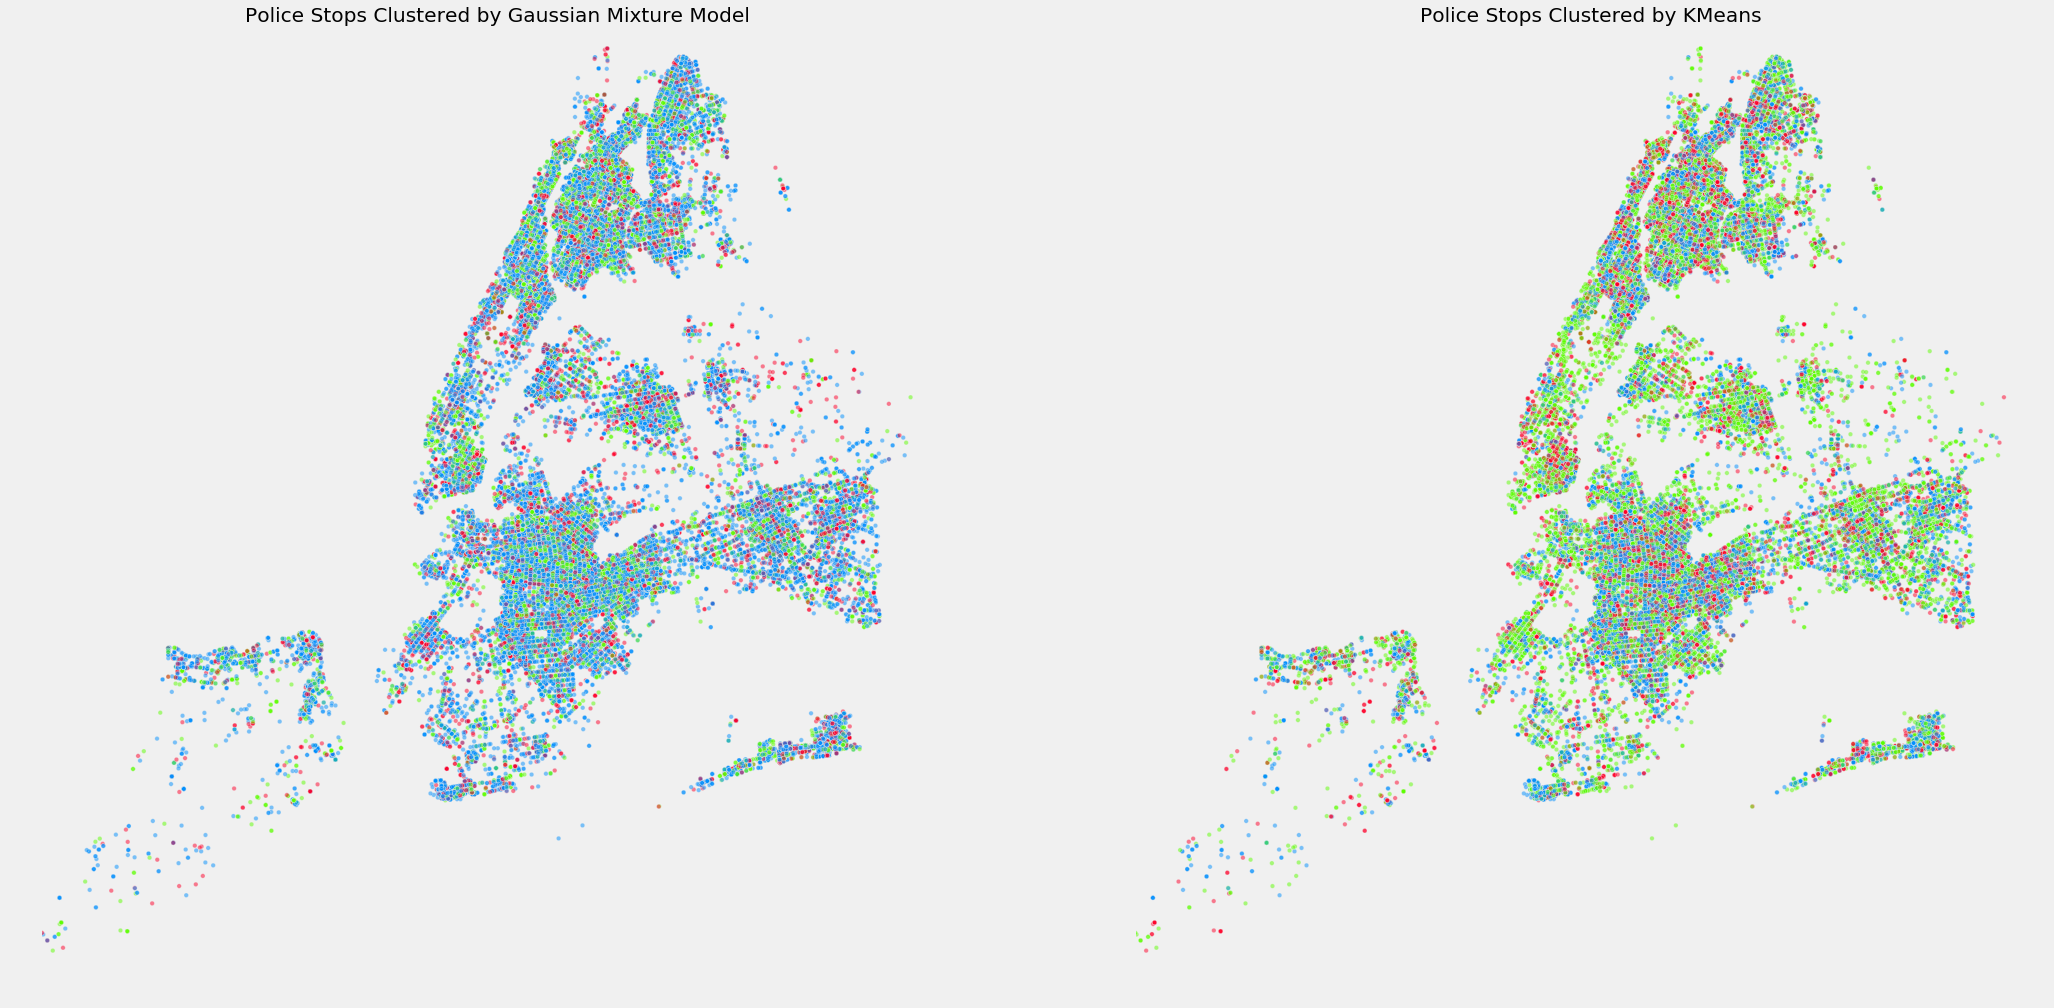

In [23]:
km = KMeans(n_clusters=3)
#db = DBSCAN()#min_samples=1000, eps=5)
#ap = AffinityPropagation(affinity='precomputed')
#ac = AgglomerativeClustering(affinity='manhattan', linkage='average')
#sc = SpectralClustering()
gm = GMM(n_components=3)

fig, ((ax1, ax2)) = plt.subplots(figsize=(32,16), nrows=1, ncols=2)


for name, c, ax in [('Gaussian Mixture Model', gm, ax1), ('KMeans', km, ax2)]:#, ('DBSCAN', db)]:
    print(name)
    labels = c.fit_predict(values)
    data['label'] = labels
    
    ax.axis('off')
    ax.scatter(data['lon'], data['lat'], c=data['label'], s=20, alpha=.5, cmap='gist_rainbow', vmin=0, vmax=3)
    ax.set_title('Police Stops Clustered by %s' % name)
    ax.set_ylim([40.49, 40.92])
    ax.set_xlim([-74.25, -73.68])

In [21]:
data.columns

Index(['lat', 'lon', 'day_Friday', 'day_Monday', 'day_Saturday', 'day_Sunday',
       'day_Thursday', 'day_Tuesday', 'day_Wednesday', 'month_April',
       'month_August', 'month_December', 'month_February', 'month_January',
       'month_July', 'month_June', 'month_March', 'month_May',
       'month_November', 'month_October', 'month_September', 'time.period_1',
       'time.period_2', 'time.period_3', 'time.period_4', 'time.period_5',
       'time.period_6', 'geometry', 'label'],
      dtype='object')

In [28]:
values[:,2:].shape

(123439, 25)